# Estimation of the mean and its uncertainty

The mean value, or some other measure of the center of a distribution, is often the first thing one looks for in a data set, or a subsample of a data set.  For example, in a long time series of surface temperature, one might want to know the mean value for each year, together with some idea of how much each mean might vary from its "true" value in an ensemble of worlds.  Here the difficulty of the frequentist interpretation is evident--we only have one world.  We can have many realizations of a numerical model of that world, though, so at least via numerical experiments it is possible to generate an ensemble of time series that are different because of some random variations in initial conditions and/or forcing.

Let's start exploring these ideas with the simplest possible case, however: random numbers generated from a known distribution, not necessarily a Gaussian.  The experimental approach illustrated here, in which we calculate statistics from a generated ensemble, is complementary to the theoretical approach, in which analytic expressions are calculated for PDFs of interest.  The advantages of the experimental approach are that (1) it doesn't require mathematical sophistication, (2) it can be applied to situations for which the analytic approach would be very difficult or even impossible, (3) it is relatively easy to understand and visualize.

## Standard Error of the Mean (SEM)

In [1]:
%matplotlib notebook

# Our standard imports:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Access to many standard distributions:
import scipy.stats as ss

We will work with 2-D arrays of random numbers.  We arbitrarily choose the first dimension to index the member of the ensemble, and the second to index sequential position (e.g. time, perhaps in a uniformly sampled time series) in the ensemble.

Start by verifying the usual formula for the Standard Error of the Mean (SEM), which gives the standard deviation of the sample mean of $N$ values from a normal distribution:
$$ \mbox{SEM} = \frac{\sigma}{\sqrt{N}}$$
where $\sigma$ is the standard deviation. 

In [9]:
nens = 10000  # number of realizations
nt = 3       # length of each time series
y = np.random.randn(nens, nt)  # sigma is 1

SEM = 1 / np.sqrt(nt)

ybar = y.mean(axis=1)
ystd = y.std(axis=1, ddof=1)
 
print("with %d points, ybar mean and std are %.5f, %.3f; SEM is %.3f" % 
      (nt, ybar.mean(), ybar.std(), SEM))
print("The mean of the estimated standard deviations is %.3f" % ystd.mean())
print("The median is %.3f" % np.median(ystd))
print("The square root of the mean estimated variance is %.3f" % 
      np.sqrt((ystd**2).mean()))

with 3 points, ybar mean and std are 0.00274, 0.572; SEM is 0.577
The mean of the estimated standard deviations is 0.885
The median is 0.825
The square root of the mean estimated variance is 1.000


In the cell above we also calculated the mean of the standard deviations, and the square root of the mean sample variance, $S^2$, using 
$$S^2 = \frac{1}{N-1}\sum_{i=0}^{N-1} (X_i - \bar{X})^2.$$
Notice that in this case we don't know the true standard deviation of the population, so we estimate it from the sample, using the `ddof` ("deduct degrees of freedom") argument to reduce the number of degrees of freedom (DOF) from $N$ to $N-1$; we lost one DOF by subtracting the sample mean.

Let's cycle through some values of nt and see how the SEM varies.  In addition to plotting the experimental and theoretical values, we will plot the *ensemble mean* of the values we get by applying the theoretical formula to *each* member of the ensemble, as if we had a single realization of an experiment, and we wished to estimate the uncertainty in the mean from that experiment.

<IPython.core.display.Javascript object>


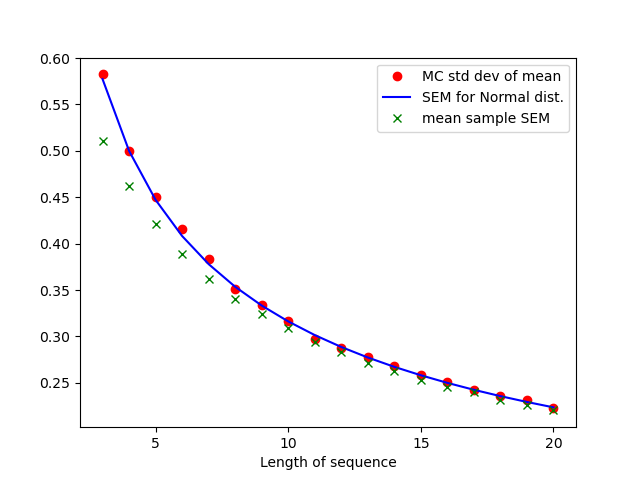

In [10]:
nens = 10000
nts = np.arange(3, 21)
n_nts = len(nts)

SEMs = 1 / np.sqrt(nts)  # theory, for normal distribution

sems_exp = np.zeros(nts.shape)
sems_sample = np.zeros(nts.shape)

for i, nt in enumerate(nts):
    y = np.random.randn(nens, nt)
    y_means = y.mean(axis=1)
    y_stds = y.std(axis=1, ddof=1)  # note ddof argument!
    sems_exp[i] = y_means.std()
    sems_sample[i] = y_stds.mean() / np.sqrt(nt)
    
fig, ax = plt.subplots()
ax.plot(nts, sems_exp, 'ro', label='MC std dev of mean')
ax.plot(nts, SEMs, 'b-', label='SEM for Normal dist.')
ax.plot(nts, sems_sample, 'gx', label='mean sample SEM')
#ax.plot(nts, np.median(sems_theory, axis=0), 'bx', label='median SEM')
ax.locator_params(axis='x', integer=True)
ax.legend(loc='upper right')
ax.set_xlabel('Length of sequence');

In [ ]:
plt.close(fig)

What is wrong with those green X-marks?  Why do they systematically underestimate the SEM?  They are based on $S$, the estimate of $\sigma$, and this is biased, as we saw in an earlier cell.

Usually what we want to know is not the SEM but the location of the tails of the sampling distribution of the mean; this can be estimated from the SEM only if the distribution is normal.  The distribution of sample means, with samples taken from a normal population, is not itself Gaussian; rather, it follows the "Student's t" distribution.  For small $N$, it has heavier tails than a Gaussian distribution.

Let's use the `scipy.stats` module to show the t distribution and compare it to the normal distribution.  (In the following cell you can change `.pdf` to `.cdf` to show the cumulative distribution function instead of the probability distribution function.)

In [ ]:
N = 5
df = N - 1
# Make instances of each distribution:
tdist = ss.t(df)
ndist = ss.norm()
# x-axis array for plotting:
x = np.linspace(-5, 5, 1001)
fig, ax = plt.subplots()
ax.plot(x, ndist.pdf(x), label='normal')
ax.plot(x, tdist.pdf(x), label=r't, $\nu = %d$' % df)
ax.legend();

In [ ]:
plt.close(fig)

We can make our own histogram to verify that this distribution is correct.  We will need a large number of samples to resolve the tails and give a reasonably smooth histogram. The t distribution applies to the following random variable:
$$\frac{\bar{X} - \mu}{\frac{S}{  \sqrt{N}}}$$
where $\mu=0$ is the *true* mean, and $S$ is the standard deviation estimated using the expression given above.  Hence, it is the deviation of the sample mean from the true mean, scaled by the *estimated* SEM.  It is this scaling--the fact that we don't know the *true* $\sigma$ of the distribution, and therefore the true SEM--that makes the distribution "t" rather than "normal".

In [ ]:
nens = 1000000  # number of realizations
nt = 5       # length of each time series
y = np.random.randn(nens, nt)
ybar = y.mean(axis=1)
ystd = y.std(axis=1, ddof=1)
normed_ybar = ybar * np.sqrt(nt) / ystd
bounds = np.linspace(-5, 5, 51)
fig, ax = plt.subplots()
ax.hist(normed_ybar, bins=bounds, density=True)
x = np.linspace(-5, 5, 501)
ax.plot(x, ss.t(nt-1).pdf(x));

In [ ]:
plt.close(fig)

What does the analogous distribution look like if instead of starting with a Gaussian random variable, you start with a uniform distribution, or with some function of a Gaussian or a uniform distribution?  Try it and find out!